<a href="https://colab.research.google.com/github/ootcoo/hemorrhage-detection/blob/main/hemorrhage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

veri setini yükle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdulkader90/brain-ct-hemorrhage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-ct-hemorrhage-dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


klasör isimlerini işle


In [ ]:
import pandas as pd
from pathlib import Path

# Ana klasör yolu
data_root = Path("/kaggle/input/brain-ct-hemorrhage-dataset/Data")

# Listeleme için boş liste
data = []

# Kategoriler: NORMAL ve Hemorrhagic/KANAMA
categories = {
    "NORMAL": data_root / "NORMAL",
    "Hemorrhage": data_root / "Hemorrhagic" / "KANAMA"
}

# Her kategori için alt klasörleri gez
for label, path in categories.items():
    for folder in path.iterdir():
        if folder.is_dir():
            for img_path in folder.glob("*.jpg"):
                data.append({
                    "PATH": str(img_path),
                    "CATEGORY": label
                })

# DataFrame oluştur
df = pd.DataFrame(data)
print(df.head())
print(df["CATEGORY"].value_counts())



                                                PATH CATEGORY
0  /kaggle/input/brain-ct-hemorrhage-dataset/Data...   NORMAL
1  /kaggle/input/brain-ct-hemorrhage-dataset/Data...   NORMAL
2  /kaggle/input/brain-ct-hemorrhage-dataset/Data...   NORMAL
3  /kaggle/input/brain-ct-hemorrhage-dataset/Data...   NORMAL
4  /kaggle/input/brain-ct-hemorrhage-dataset/Data...   NORMAL
CATEGORY
NORMAL        4105
Hemorrhage    2667
Name: count, dtype: int64


Verileri ve etiketleri görelim

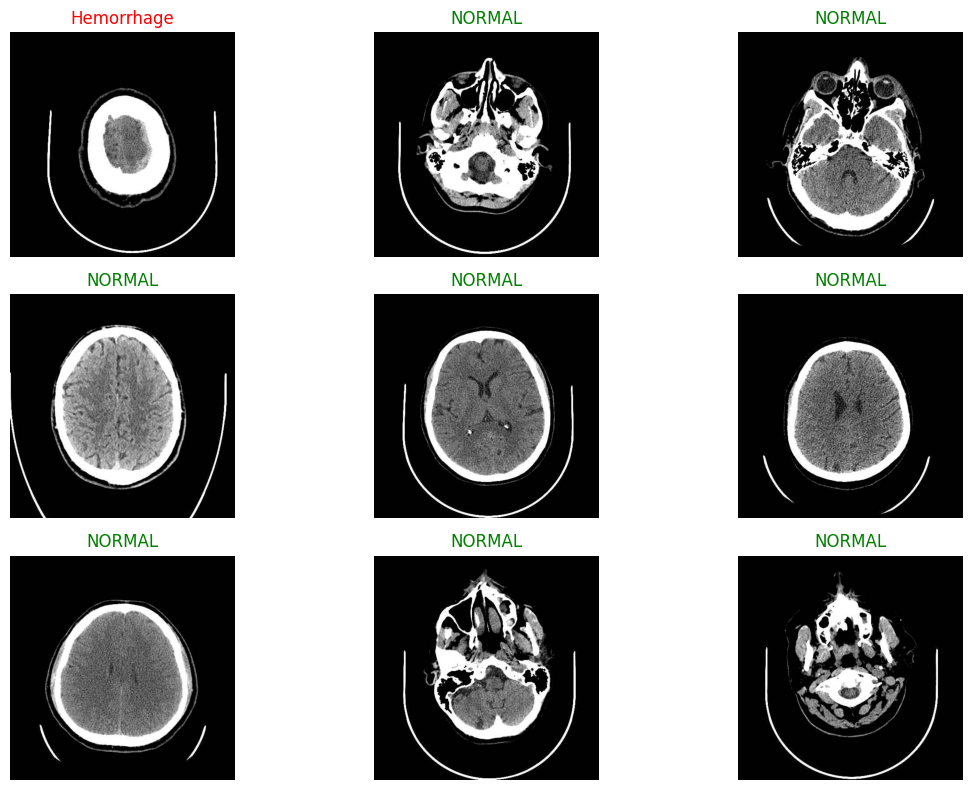

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random


sample_count = 9

# Rastgele
samples = df.sample(sample_count)


cols = 3
rows = sample_count // cols + (sample_count % cols > 0)

plt.figure(figsize=(12, 8))

for i, (path, label) in enumerate(zip(samples["PATH"], samples["CATEGORY"])):

    img = cv2.imread(path)

    if img is None:
        continue  # bozuk dosya varsa atla

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(label, color="red" if label == "Hemorrhage" else "green")
    plt.axis("off")

plt.tight_layout()
plt.show()


ön işlemeler

görselleri yükleme

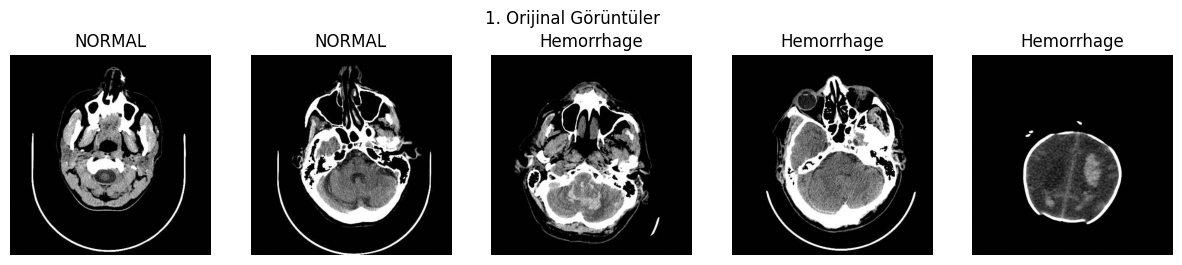

(512, 512)


In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

df_copy = df.copy()  # Orijinali bozmamak için kopya

df_copy["image"] = df_copy["PATH"].apply(lambda p: cv2.imread(p, cv2.IMREAD_GRAYSCALE))


indices = random.sample(range(len(df)), 5)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(df_copy["image"].iloc[idx], cmap='gray')
    plt.title(df_copy["CATEGORY"].iloc[idx])
    plt.axis('off')
plt.suptitle("1. Orijinal Görüntüler")
plt.show()
print(df_copy["image"].iloc[0].shape)  # örnek bir görüntü shape'i

kafatasını çıkarma

In [ ]:
# import cv2
# import numpy as np
# from skimage.measure import label, regionprops

# def skull_strip_v2(img, min_area=1000):
#     """
#     1) Griye çevir + uint8
#     2) Median blur ile gürültü azaltma
#     3) Bone mask: parlak kemikleri threshold ile ayıkla
#     4) Bone mask'ı dilate et -> kemik halkası tam kapanır
#     5) Invert bone mask = prelim brain mask
#     6) Morph open/close ile temizle
#     7) Flood-fill ile delikleri doldur
#     8) En büyük CC ile nihai brain mask
#     9) Skull-stripped = img * brain_mask
#     """
#     if img is None or img.size == 0:
#         return img, np.zeros_like(img)

#     # 1) Griye çevir + uint8
#     if img.ndim == 3 and img.shape[2] == 3:
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = img.copy()
#     if gray.dtype != np.uint8:
#         gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

#     # 2) Gürültü azaltma

#     blurred = cv2.GaussianBlur(gray, (5, 5), 0)

#     # 3) Bone mask: kemik pikselleri (çok parlak)
#     _, bone = cv2.threshold(blurred, 220, 255, cv2.THRESH_BINARY)

#     # 4) Bone mask'ı dilate et
#     kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
#     bone_dil = cv2.dilate(bone, kern, iterations=2)

#     # 5) Invert = prelim brain
#     prelim = cv2.bitwise_not(bone_dil)

#     # 6) Morph cleaning
#     clean = cv2.morphologyEx(prelim, cv2.MORPH_CLOSE, kern, iterations=2)
#     clean = cv2.morphologyEx(clean, cv2.MORPH_OPEN, kern, iterations=1)

#     # 7) Flood-fill delikleri kapat
#     h, w = clean.shape
#     ff = clean.copy()
#     mask_ff = np.zeros((h+2, w+2), np.uint8)
#     cv2.floodFill(ff, mask_ff, (0,0), 255)
#     ff_inv = cv2.bitwise_not(ff)
#     filled = clean | ff_inv

#     # 8) En büyük CC seç
#     lbl = label(filled)
#     props = [p for p in regionprops(lbl) if p.area >= min_area]
#     if props:
#         largest = max(props, key=lambda p: p.area)
#         brain_mask = (lbl == largest.label).astype(np.uint8) * 255
#     else:
#         brain_mask = np.zeros_like(gray, dtype=np.uint8)

#     # 9) Strip
#     skull_stripped = cv2.bitwise_and(gray, gray, mask=brain_mask)

#     return skull_stripped, brain_mask


# # 1) apply ile stripping ve mask üret
# results = df_copy["image"].apply(lambda im: skull_strip_v2(im, min_area=1000))

# # 2) (“stripped”, “mask”) ikililerini aç
# df_copy[["stripped", "mask"]] = pd.DataFrame(results.tolist(), index=df_copy.index)


# # Kontrol et:
# print(df_copy.head())

# # 3)
# import random
# sample_idxs = random.sample(list(df_copy.index), 5)

# plt.figure(figsize=(15, 5))
# for i, idx in enumerate(sample_idxs):
#     orig = df_copy.at[idx, "image"]
#     m    = df_copy.at[idx, "mask"]
#     s    = df_copy.at[idx, "stripped"]
#     cat  = df_copy.at[idx, "CATEGORY"]

#     # Orijinal
#     plt.subplot(3, 5, i+1)
#     plt.imshow(orig, cmap="gray")
#     plt.title(cat, color=("red" if cat=="Hemorrhage" else "green"))
#     plt.axis("off")

#     # Mask
#     plt.subplot(3, 5, 5 + i+1)
#     plt.imshow(m, cmap="gray")
#     plt.title("Mask")
#     plt.axis("off")

#     # Stripped
#     plt.subplot(3, 5, 10 + i+1)
#     plt.imshow(s, cmap="gray")
#     plt.title("Stripped")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

# # 3) Orijinal image sütununu strip’lenmiş ile değiştir
# df_copy["image"] = df_copy["stripped"]

# # artık stripped ve mask sütunları fazlalık, sil
# df_copy.drop(columns=["stripped","mask"], inplace=True)

# # Kontrol
# print(df_copy.columns)  # sadece ['PATH','CATEGORY','image'] kaldı
# print(df_copy["image"].iloc[0].shape)  # örnek bir görüntü shape'i


kırpma


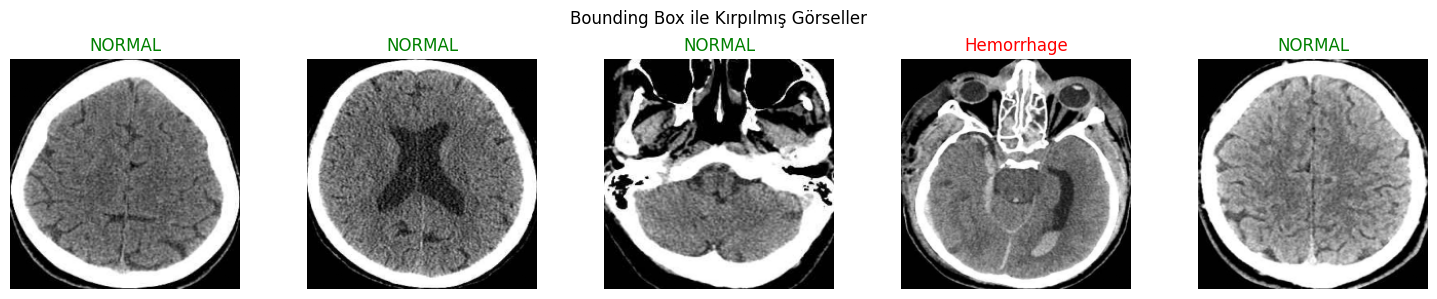

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


def preprocess_crop(img, target_size=(224, 224)):
    """
    GaussianBlur + Otsu threshold + morfolojik temizlik + bounding box crop + resize.
    Eğer bounding box çıkmazsa merkezden ROI alınır.
    """
    # --- 1. Tip kontrolü
    if img is None:
        raise ValueError("Görüntü boş!")
    if img.ndim == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img.copy()

    # --- 2. float32 ise uint8'e dönüştür
    if img_gray.dtype != np.uint8:
        img_gray = (img_gray * 255).clip(0, 255).astype(np.uint8)



    # --- 4. GaussianBlur (Otsu için histogram yumuşatma)
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # --- 5. Otsu threshold
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # --- 6. Morfolojik aç-kapa
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # --- 7. Bounding Box veya fallback ROI
    coords = cv2.findNonZero(mask)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        cropped = img_gray[y:y+h, x:x+w]
    else:
        # ROI fallback (görüntünün merkezi)
        h, w = img_gray.shape
        roi_w = int(w * 0.6)
        roi_h = int(h * 0.6)
        cx, cy = w // 2, h // 2
        x1 = max(cx - roi_w // 2, 0)
        y1 = max(cy - roi_h // 2, 0)
        x2 = min(cx + roi_w // 2, w)
        y2 = min(cy + roi_h // 2, h)
        cropped = img_gray[y1:y2, x1:x2]

    # --- 8. Resize
    resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
    return resized


# 1) preprocess adımı
df_copy["image"] = df_copy["image"].apply(
    lambda img: preprocess_crop(img, target_size=(224, 224))
)

# 2)
def show_random(df, column="image", num=5, title="Kırpılmış Görseller"):
    indices = random.sample(range(len(df)), num)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img   = df[column].iloc[idx]
        label = df["CATEGORY"].iloc[idx]
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label, color='red' if label=="Hemorrhage" else 'green')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# 3)
show_random(df_copy, column="image", title="Bounding Box ile Kırpılmış Görseller")

pencereleme

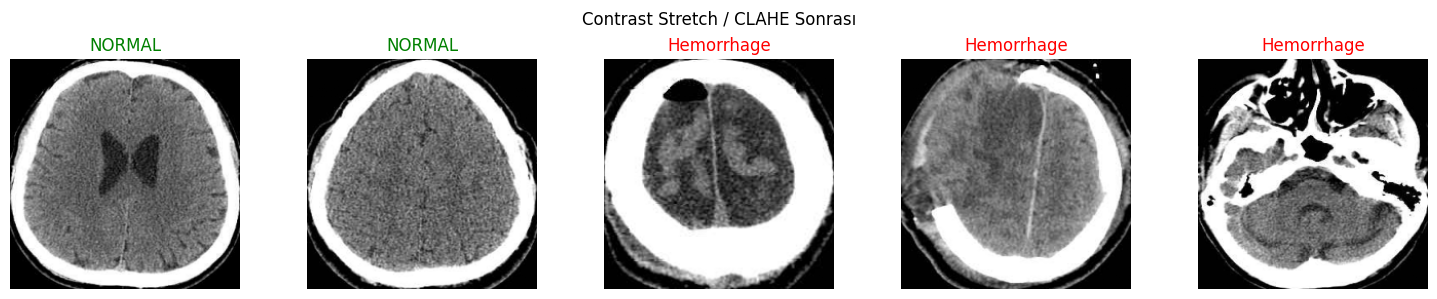

In [ ]:
def contrast_stretch(img, p_low=2, p_high=98, return_float=False):
    """
    uint8 görüntü için yüzde tabanlı pencereleme:
      p_low, p_high: histogramın yüzde kaçlık noktaları
      return_float: True ise [0,1] float32 verir, False ise uint8 [0,255]
    """
    flat = img.flatten().astype(np.float32)
    lo, hi = np.percentile(flat, [p_low, p_high])
    # clip & normalize
    stretched = np.clip(img.astype(np.float32), lo, hi)
    stretched = (stretched - lo) / (hi - lo)
    if return_float:
        return stretched
    return (stretched * 255).astype(np.uint8)

df_copy["image"] = df_copy["image"].apply(
    lambda im: contrast_stretch(im, p_low=1, p_high=99)
)



indices = random.sample(range(len(df_copy)), 5)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1,5,i+1)
    plt.imshow(df_copy["image"].iloc[idx], cmap="gray")
    lbl = df_copy.at[idx, "CATEGORY"]
    plt.title(lbl, color=("red" if lbl=="Hemorrhage" else "green"))
    plt.axis("off")
plt.suptitle("Contrast Stretch / CLAHE Sonrası")
plt.tight_layout()
plt.show()


clahe

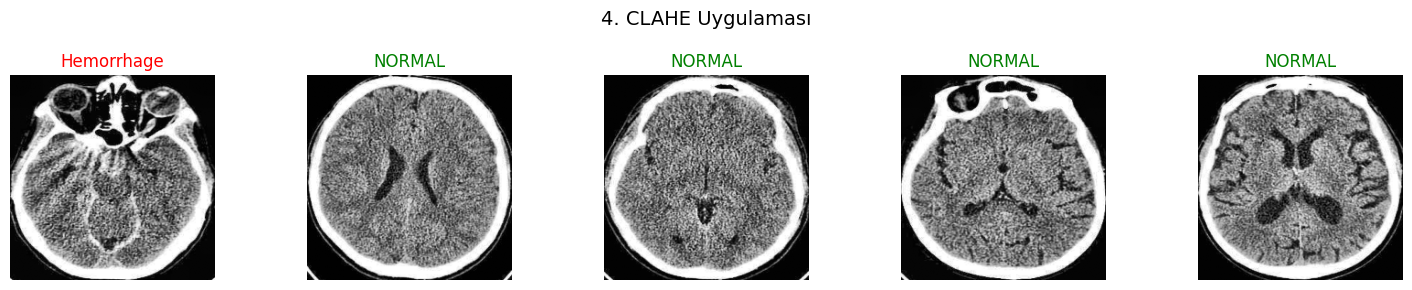

In [ ]:
import cv2, numpy as np, random, matplotlib.pyplot as plt

# 1) CLAHE nesnesini bir kez oluştur
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def apply_clahe(img):
    if img is None or img.size == 0:
        return img
    # 2) Gerekirse griye çevir
    if img.ndim==3 and img.shape[2]==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 3) Gerekirse uint8’e dönüştür
    if img.dtype != np.uint8:
        img = (img * 255).clip(0,255).astype(np.uint8)
    # 4) CLAHE uygula
    return clahe.apply(img)

# 5) Uygula
df_copy["image"] = df_copy["image"].apply(apply_clahe)

# 6) Görselleştir
# 5 rastgele örnek seçelim
sample_idxs = random.sample(list(df_copy.index), 5)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(sample_idxs):
    img = df_copy.at[idx, "image"]
    lbl = df_copy.at[idx, "CATEGORY"]

    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(lbl, color=("red" if lbl=="Hemorrhage" else "green"), fontsize=12)
    plt.axis("off")

plt.suptitle("4. CLAHE Uygulaması", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

normalize

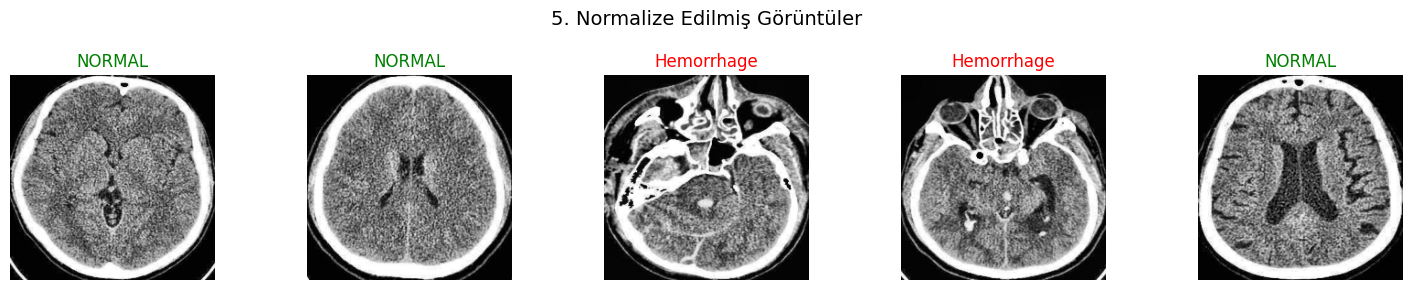

In [ ]:
# 1) Min–max normalize fonksiyonu
def normalize_minmax(img):
    if img is None or img.size == 0:
        return img
    img = img.astype(np.float32)
    mn, mx = img.min(), img.max()
    return (img - mn) / (mx - mn + 1e-8)

# 2)
df_copy["image"] = df_copy["image"].apply(normalize_minmax)

# 3) Görselleştir
indices = random.sample(range(len(df_copy)), 5)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(df_copy["image"].iloc[idx], cmap='gray', vmin=0, vmax=1)
    lbl = df_copy.at[idx, "CATEGORY"]
    plt.title(lbl, color=('red' if lbl=="Hemorrhage" else 'green'))
    plt.axis('off')
plt.suptitle("5. Normalize Edilmiş Görüntüler", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


VGG16 ile dataframei deneme

In [ ]:

import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1) Görselleri aynı shape’te stack et ve shape tutarlılığını kontrol et
shapes = [img.shape for img in df_copy["image"]]
assert len(set(shapes)) == 1, f"Resimler farklı boyutta: {set(shapes)}"
X = np.stack(df_copy["image"].values)                # (N, H, W)

# 2) Grayscale → 3-kanal (RGB)
X = np.repeat(X[..., np.newaxis], 3, axis=-1)        # (N, H, W, 3)

# 3) Tip dönüşümü ve ImageNet önişleme
X = X.astype("float32")
X = preprocess_input(X)                              # BGR format, mean subtraction vs.

# 4) Etiketleri integer (0/1) olarak encode et
le     = LabelEncoder()
y_int  = le.fit_transform(df_copy["CATEGORY"])       # Hemorrhage/Normal → 0/1
print("Label sınıfları:", le.classes_)               # ['Hemorrhage' 'Normal']

# 5) Train/Test split (sparse etiketlerle)
X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_int,
    test_size=0.20,
    stratify=y_int,
    random_state=42
)

# 6) Kontrol
print(f"X_train: {X_train.shape}, dtype={X_train.dtype}")
print(f"X_test : {X_test.shape}, dtype={X_test.dtype}")
print(f"y_train_int (sparse): {y_train_int.shape}, unique labels = {np.unique(y_train_int)}")
print(f"y_test_int  (sparse): {y_test_int.shape}, unique labels = {np.unique(y_test_int)}")

# Asıl dağılım kontrolü
train_counts = np.bincount(y_train_int)
test_counts  = np.bincount(y_test_int)
print(f"Sınıf dağılımı (train): {{'{le.classes_[0]}': {train_counts[0]}, '{le.classes_[1]}': {train_counts[1]}}}")
print(f"Sınıf dağılımı ( test): {{'{le.classes_[0]}': {test_counts[0]}, '{le.classes_[1]}': {test_counts[1]}}}")



Label sınıfları: ['Hemorrhage' 'NORMAL']
X_train: (5417, 224, 224, 3), dtype=float32
X_test : (1355, 224, 224, 3), dtype=float32
y_train_int (sparse): (5417,), unique labels = [0 1]
y_test_int  (sparse): (1355,), unique labels = [0 1]
Sınıf dağılımı (train): {'Hemorrhage': 2133, 'NORMAL': 3284}
Sınıf dağılımı ( test): {'Hemorrhage': 534, 'NORMAL': 821}


In [ ]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models       import Model
from tensorflow.keras.layers       import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers   import Adam

# 1) Base model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

# 2) Önce tüm katmanları dondur
base_model.trainable = False

# 3) Sondan 10 katmanı aç (BatchNorm’ları kapalı bırakmak çoğunlukla daha iyi sonuç verir)
for layer in base_model.layers[-10:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# 4) Üst katmanları ekle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)   # tek nöron → binary

model = Model(inputs=base_model.input, outputs=output)

# 5) Compile (katmanlar ayarlandıktan sonra)
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 13,635,073 (52.01 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
  EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]


history = model.fit(
    X_train, y_train_int,
    validation_data=(X_test, y_test_int),
    epochs=50,
    batch_size=32,
    shuffle=True
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


170/170 ━━━━━━━━━━━━━━━━━━━━ 62s 232ms/step - accuracy: 0.5586 - loss: 0.7660 - val_accuracy: 0.6059 - val_loss: 0.6920
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.6502 - loss: 0.6389 - val_accuracy: 0.7092 - val_loss: 0.5707
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.7126 - loss: 0.5497 - val_accuracy: 0.7823 - val_loss: 0.4935
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.7838 - loss: 0.4518 - val_accuracy: 0.8192 - val_loss: 0.3933
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.8429 - loss: 0.3641 - val_accuracy: 0.8236 - val_loss: 0.4083
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.8717 - loss: 0.2962 - val_accuracy: 0.8974 - val_loss: 0.2638
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.9232 - loss: 0.2106 - val_accuracy: 0.7956 - val_loss: 0.4038
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.9083 - loss: 0.2186 - val

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import seaborn as sns


# 1) Tahmin
y_pred_prob   = model.predict(X_test)        # shape (N,1)
y_pred        = y_pred_prob.flatten()       # shape (N,)
y_pred_binary = (y_pred > 0.5).astype(int)  # 0 veya 1



# 2) Classification report (precision, recall, f1-score sınıf bazında)
print("Classification Report:\n")
print(classification_report(
    y_test_int,
    y_pred_binary,
    target_names=[le.classes_[0], le.classes_[1]]
))

# 3) Global metrikler
prec = precision_score(y_test_int, y_pred_binary)
rec  = recall_score(y_test_int, y_pred_binary)
f1   = f1_score(y_test_int, y_pred_binary)
auc  = roc_auc_score(y_test_int, y_pred)

print(f"Overall Precision: {prec:.4f}")
print(f"Overall Recall   : {rec:.4f}")
print(f"Overall F1-score : {f1:.4f}")
print(f"ROC AUC          : {auc:.4f}")

# 4) Confusion Matrix (opsiyonel, daha önce yaptık)
cm = confusion_matrix(y_test_int, y_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 5) ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


NameError: name 'model' is not defined

In [ ]:
# 1. Eğitim seti üzerinde değerlendirme
train_loss, train_acc = model.evaluate(X_train, y_train_int, verbose=0)
# 2. Test seti üzerinde değerlendirme
test_loss,  test_acc  = model.evaluate(X_test,  y_test_int,  verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f" Test Accuracy: {test_acc:.4f}")
print(f"Generalization Gap: {train_acc - test_acc:.4f}")


Train Accuracy: 0.9939
 Test Accuracy: 0.9756
Generalization Gap: 0.0183


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models       import Model
from tensorflow.keras.layers       import Dense, GlobalAveragePooling2D, Input

def build_model():
    base = VGG16(
        weights='imagenet',
        include_top=False,
        input_tensor=Input(shape=(224,224,3))
    )
    base.trainable = False
    for layer in base.layers[-10:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    m = Model(base.input, out)
    return m

# Stratified K-Fold hazırlık
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
val_accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_int), 1):
    # 1) Modeli inşa et ve ağırlıkları yükle
    model_fold = build_model()
    model_fold.set_weights(model.get_weights())

    # 2) Her fold için yeni optimizer örneği oluştur
    opt = tf.keras.optimizers.Adam(1e-5)
    model_fold.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 3) Veri setini ayır
    X_tr, y_tr = X[train_idx], y_int[train_idx]
    X_va, y_va = X[val_idx],   y_int[val_idx]

    # 4) Fit & evaluate
    model_fold.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=5,
        batch_size=32,
        verbose=0
    )
    loss, acc = model_fold.evaluate(X_va, y_va, verbose=0)
    print(f"Fold {fold}: val_acc = {acc:.4f}")
    val_accs.append(acc)

print(f"\nMean val_acc: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_149']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_149']
Received: inputs=Tensor(shape=(2, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expect

Fold 1: val_acc = 0.9973


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_171']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_171']
Received: inputs=Tensor(shape=(3, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_171']
Received: inputs=Tensor(shape=(17, 224, 224, 3))
  warnings.warn(msg)


Fold 2: val_acc = 0.9965


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_193']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_193']
Received: inputs=Tensor(shape=(3, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_193']
Received: inputs=Tensor(shape=(17, 224, 224, 3))
  warnings.warn(msg)


Fold 3: val_acc = 0.9960

Mean val_acc: 0.9966 ± 0.0006


diğer modellerle transfer öğrenme

In [ ]:
# --- Hücre 1: Modellerin Eğitimi ve Test Verisinin Saklanması ---
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import resnet50, mobilenet_v2
from tensorflow.keras.applications.efficientnet import (
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    preprocess_input as eff_preprocess
)



# Görselleri hazırlayan fonksiyon
def prepare_images(images, preprocess_fn, target_size):
    X = np.stack(images)
    if X.shape[1:3] != target_size:
        X = np.array([tf.image.resize(img, target_size).numpy() for img in X])
    if X.ndim == 3 or X.shape[-1] == 1:
        X = np.repeat(X[..., np.newaxis], 3, axis=-1)
    return preprocess_fn(X.astype("float32"))

# Parametreler
img_size   = df_copy["image"].iloc[0].shape[:2]
batch_size = 32
epochs     = 30

# Etiketleri integer’a çevir
le = LabelEncoder()
y  = le.fit_transform(df_copy["CATEGORY"])  # Hemorrhage/Normal → 0/1

# Model konfigürasyonları
model_confs = {
    'ResNet50': {
        'model_fn':    lambda: resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(*img_size,3)),
        'pre_fn':      resnet50.preprocess_input,
        'input_size':  img_size
    },
    'MobileNetV2': {
        'model_fn':    lambda: mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size,3)),
        'pre_fn':      mobilenet_v2.preprocess_input,
        'input_size':  img_size
    },
    'EfficientNetB0': {
        'model_fn':    lambda: EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*img_size,3)),
        'pre_fn':      eff_preprocess,
        'input_size':  img_size
    },
    'EfficientNetB1': {
        'model_fn':    lambda: EfficientNetB1(weights='imagenet', include_top=False, input_shape=(*img_size,3)),
        'pre_fn':      eff_preprocess,
        'input_size':  img_size
    },
    'EfficientNetB2': {
        'model_fn':    lambda: EfficientNetB2(weights='imagenet', include_top=False, input_shape=(*img_size,3)),
        'pre_fn':      eff_preprocess,
        'input_size':  img_size
    },
    'EfficientNetB3': {
        'model_fn':    lambda: EfficientNetB3(weights='imagenet', include_top=False, input_shape=(*img_size,3)),
        'pre_fn':      eff_preprocess,
        'input_size':  img_size
    },
}

# Eğitim döngüsü
models_dict = {}
test_data   = {}

for name, conf in model_confs.items():
    print(f"\n>>> {name} ile eğitiliyor …")
    # Veri hazırlık + split
    X = prepare_images(df_copy["image"].values, conf['pre_fn'], conf['input_size'])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Model oluştur
    base = conf['model_fn']()
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(base.input, output)

    # Compile
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Fit
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
        ],
        verbose=1
    )

    print(f"{name} — En iyi val_accuracy: {max(history.history['val_accuracy']):.4f}")

    # Eğitilen modeli ve test setini sakla
    models_dict[name] = model
    test_data[name]   = (X_test, y_test)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

>>> ResNet50 ile eğitiliyor …
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.5319 - loss: 0.7480 - val_accuracy: 0.6059 - val_loss: 0.6701 - learning_rate: 1.0000e-04
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.5445 - loss: 0.7287 - val_accuracy: 0.6059 - val_loss: 0.6690 - learning_rate: 1.0000e-04
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.5523 - loss: 0.7078 - val_accuracy: 0.6059 - val_loss: 0.6687 - learning_rate: 1.0000e-04
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.5739 - loss: 0.6937 - val_accuracy: 0.6059 - val_loss: 0.6674 - learning_rate: 1.0000e-04
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.5723 - loss: 0.6906 - val_accuracy: 0.6059 - val_loss: 0.6667 - learning_rate: 1.0000e-04
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/

model metrikleri


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step

=== ResNet50 Değerlendirmesi ===
Classification Report:
              precision    recall  f1-score   support

  Hemorrhage       0.93      0.03      0.05       534
      NORMAL       0.61      1.00      0.76       821

    accuracy                           0.62      1355
   macro avg       0.77      0.51      0.40      1355
weighted avg       0.74      0.62      0.48      1355

Confusion Matrix:
[[ 14 520]
 [  1 820]]
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step

=== MobileNetV2 Değerlendirmesi ===
Classification Report:
              precision    recall  f1-score   support

  Hemorrhage       0.00      0.00      0.00       534
      NORMAL       0.61      1.00      0.75       821

    accuracy                           0.61      1355
   macro avg       0.30      0.50      0.38      1355
weighted avg       0.37      0.61      0.46      1355

Confusion Matrix:
[[  0 534]
 [  0 821]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step

=== EfficientNetB0 Değerlendirmesi ===
Classification Report:
              precision    recall  f1-score   support

  Hemorrhage       0.00      0.00      0.00       534
      NORMAL       0.61      1.00      0.75       821

    accuracy                           0.61      1355
   macro avg       0.30      0.50      0.38      1355
weighted avg       0.37      0.61      0.46      1355

Confusion Matrix:
[[  0 534]
 [  0 821]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step

=== EfficientNetB1 Değerlendirmesi ===
Classification Report:
              precision    recall  f1-score   support

  Hemorrhage       0.00      0.00      0.00       534
      NORMAL       0.61      1.00      0.75       821

    accuracy                           0.61      1355
   macro avg       0.30      0.50      0.38      1355
weighted avg       0.37      0.61      0.46      1355

Confusion Matrix:
[[  0 534]
 [  0 821]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step

=== EfficientNetB2 Değerlendirmesi ===
Classification Report:
              precision    recall  f1-score   support

  Hemorrhage       0.00      0.00      0.00       534
      NORMAL       0.61      1.00      0.75       821

    accuracy                           0.61      1355
   macro avg       0.30      0.50      0.38      1355
weighted avg       0.37      0.61      0.46      1355

Confusion Matrix:
[[  0 534]
 [  0 821]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 234ms/step

=== EfficientNetB3 Değerlendirmesi ===
Classification Report:
              precision    recall  f1-score   support

  Hemorrhage       0.43      0.01      0.01       534
      NORMAL       0.61      1.00      0.75       821

    accuracy                           0.61      1355
   macro avg       0.52      0.50      0.38      1355
weighted avg       0.54      0.61      0.46      1355

Confusion Matrix:
[[  3 531]
 [  4 817]]


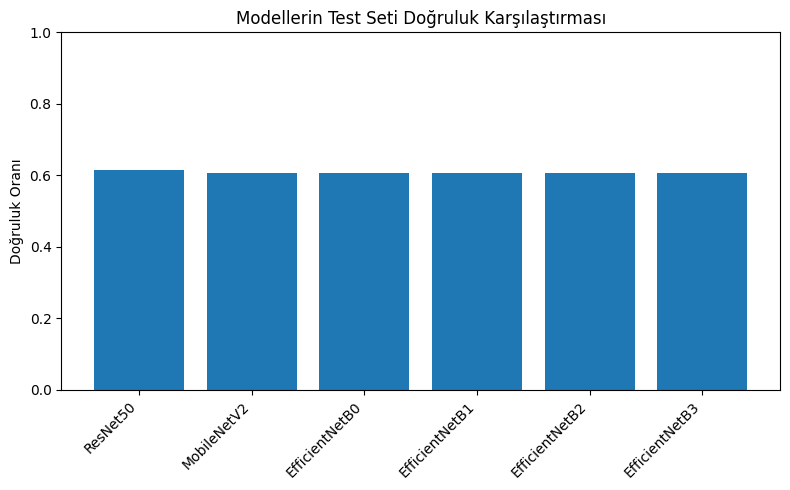

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

metrics = {}

for name, model in models_dict.items():
    X_test, y_test = test_data[name]
    # Tahmin & eşik
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype(int).flatten()

    # Raporlar
    print(f"\n=== {name} Değerlendirmesi ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Test doğruluğunu kaydet
    metrics[name] = accuracy_score(y_test, y_pred)

# Bar grafiği
names = list(metrics.keys())
accs  = [metrics[n] for n in names]

plt.figure(figsize=(8,5))
plt.bar(names, accs)
plt.title("Modellerin Test Seti Doğruluk Karşılaştırması")
plt.ylabel("Doğruluk Oranı")
plt.ylim(0,1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


CNN modeli

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, MaxPooling2D,
    Reshape, Bidirectional, LSTM, GRU,
    Flatten, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 1. Veri Hazırlığı ---
X = np.stack(df_copy["image"].values)
if X.ndim == 3: X = X[..., None]
X = X.astype("float32")
# grayscale → RGB
X = np.repeat(X, 3, axis=-1)

y_int = LabelEncoder().fit_transform(df_copy["CATEGORY"].values)
y_cat = to_categorical(y_int, num_classes=2)

X_t, X_test, y_t, y_test = train_test_split(
    X, y_cat, test_size=0.15, stratify=y_cat, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_t, y_t, test_size=0.1765, stratify=y_t, random_state=42
)

# --- 2. Augmentation ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8,1.2),
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen   = val_datagen.flow(X_val,   y_val,   batch_size=32, shuffle=False)

# --- 3. Model: VGG16 + Conv Blokları + RNN ---
inp = Input(shape=(224,224,3))
base = VGG16(weights='imagenet', include_top=False, input_tensor=inp)
base.trainable = False

x = base.output
# Konv blokları (daha büyük kernel)
for filters, kernel, pool in [(32,7,True), (64,5,True), (128,3,True)]:
    x = Conv2D(filters, (kernel,kernel), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    if pool:
        x = MaxPooling2D((2,2), padding='same')(x)

# RNN için zaman boyutu oluştur
# x.shape = (None, h, w, c) → time_steps = h, features = w*c
shape = tf.keras.backend.int_shape(x)
time_steps, features = shape[1], shape[2]*shape[3]
x = Reshape((time_steps, features))(x)

# İki katmanlı bidirectional RNN
x = Bidirectional(LSTM(32, return_sequences=True,
                       dropout=0.5, recurrent_dropout=0.5))(x)
x = Bidirectional(GRU(32, return_sequences=False,
                      dropout=0.5, recurrent_dropout=0.5))(x)

# Karar katmanları
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(2, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

# --- 4. Compile & Callbacks ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    EarlyStopping(monitor='val_auc', mode='max',
                  patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max',
                      factor=0.3, patience=2,
                      min_lr=1e-7, verbose=1)
]

# --- 5A. Yalnızca Head Eğitimi ---
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

# --- 5B. Fine‐Tuning: Base’in son 10 katmanını aç ---
for layer in base.layers[-10:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

# --- 6. Test Değerlendirmesi ---
loss, acc, auc = model.evaluate(b
    val_datagen.flow(X_test, y_test, batch_size=32), verbose=1
)
print(f"Test Loss: {loss:.4f} — Acc: {acc:.4f} — AUC: {auc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 75s 408ms/step - accuracy: 0.5773 - auc: 0.5929 - loss: 0.6812 - val_accuracy: 0.6063 - val_auc: 0.6347 - val_loss: 0.6710 - learning_rate: 1.0000e-04
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 59s 396ms/step - accuracy: 0.6010 - auc: 0.6067 - loss: 0.6759 - val_accuracy: 0.6063 - val_auc: 0.6304 - val_loss: 0.6692 - learning_rate: 1.0000e-04
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5931 - auc: 0.5968 - loss: 0.6779
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
149/149 ━━━━━━━━━━━━━━━━━━━━ 59s 396ms/step - accuracy: 0.5932 - auc: 0.5969 - loss: 0.6778 - val_accuracy: 0.6063 - val_auc: 0.6341 - val_loss: 0.6710 - learning_rate: 1.0000e-04
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 59s 397ms/step - accuracy: 0.6193 - auc: 0.6184 - loss: 0.6693 - val_accuracy: 0.6063 - val_auc: 0.6294 - val_loss: 0.6684 - learning_rate: 3.0000e-05
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.

In [ ]:
# Varsayım: Daha önce model.fit() ile eğittiğinizde dönen 'history' objeniz var.
# history.history içinde her epoch’a ait metrikler saklı.

# 1. Epoch’lara ait listeleri al
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
train_auc  = history.history['auc']
val_auc    = history.history['val_auc']

# 2. Epoch bazlı farkları hesapla ve yazdır
for i, (tl, vl, ta, va) in enumerate(zip(train_loss, val_loss, train_acc, val_acc), start=1):
    loss_delta = vl - tl
    acc_delta  = ta - va
    print(f"Epoch {i:02d} → Loss Δ: {loss_delta:+.4f},  Acc Δ: {acc_delta:+.4f}")


Epoch 01 → Loss Δ: -0.1580,  Acc Δ: +0.1528
Epoch 02 → Loss Δ: -0.0665,  Acc Δ: +0.1255
Epoch 03 → Loss Δ: -0.1293,  Acc Δ: -0.0587
Epoch 04 → Loss Δ: +0.1172,  Acc Δ: +0.1137
Epoch 05 → Loss Δ: +0.4350,  Acc Δ: +0.0733
Epoch 06 → Loss Δ: +0.6046,  Acc Δ: +0.1022
Epoch 07 → Loss Δ: +0.0759,  Acc Δ: +0.0551
Epoch 08 → Loss Δ: +0.3680,  Acc Δ: +0.1335
Epoch 09 → Loss Δ: +0.7249,  Acc Δ: +0.3184
Epoch 10 → Loss Δ: +0.3808,  Acc Δ: +0.2133
Epoch 11 → Loss Δ: -0.0421,  Acc Δ: -0.0425
Epoch 12 → Loss Δ: -0.0007,  Acc Δ: -0.0036
Epoch 13 → Loss Δ: +0.1245,  Acc Δ: +0.0687
Epoch 14 → Loss Δ: -0.0227,  Acc Δ: -0.0152
Epoch 15 → Loss Δ: -0.0050,  Acc Δ: -0.0054
Epoch 16 → Loss Δ: +0.0678,  Acc Δ: +0.0322
Epoch 17 → Loss Δ: -0.0275,  Acc Δ: -0.0287
Epoch 18 → Loss Δ: +0.2075,  Acc Δ: +0.1325
Epoch 19 → Loss Δ: -0.0082,  Acc Δ: -0.0136
Epoch 20 → Loss Δ: +0.3450,  Acc Δ: +0.2043
Epoch 21 → Loss Δ: +0.1135,  Acc Δ: +0.0668
Epoch 22 → Loss Δ: +0.0466,  Acc Δ: +0.0186
Epoch 23 → Loss Δ: +0.0239,  Acc

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# X ve y_int’in (etiketler) tanımlı olduğunu varsayıyoruz

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Sonuçları depolamak için
results = {
    'train_loss': [], 'val_loss': [],
    'train_acc':  [], 'val_acc':  [],
    'train_auc':  [], 'val_auc':  []
}

def create_model():
    base = VGG16(weights='imagenet', include_top=False, input_shape=X.shape[1:])
    base.trainable = False
    x = base.output
    # Buraya dilerseniz ekstra conv+pool bloklarını ekleyin…
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    m = Model(base.input, out)
    m.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return m

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_int), start=1):
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y_int[train_idx], y_int[val_idx]

    model = create_model()
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=15, batch_size=32,
        verbose=0
    )

    # Son epoch metriklerini kaydet
    results['train_loss'].append(hist.history['loss'][-1])
    results['val_loss'].append(hist.history['val_loss'][-1])
    results['train_acc'].append(hist.history['accuracy'][-1])
    results['val_acc'].append(hist.history['val_accuracy'][-1])
    results['train_auc'].append(hist.history['auc'][-1])
    results['val_auc'].append(hist.history['val_auc'][-1])

# Fold’lar arası ortalama ve standart sapma
import numpy as np
for metric, vals in results.items():
    print(f"{metric:>10s}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")

# Ortalama farklar (overfitting göstergesi)
avg_acc_diff = np.mean(results['train_acc']) - np.mean(results['val_acc'])
avg_loss_diff = np.mean(results['val_loss']) - np.mean(results['train_loss'])
print(f"\nOrtalama Acc farkı (train - val): {avg_acc_diff:.4f}")
print(f"Ortalama Loss farkı (val - train): {avg_loss_diff:.4f}")


train_loss: 0.6778 ± 0.0011
  val_loss: 0.6699 ± 0.0008
 train_acc: 0.5956 ± 0.0042
   val_acc: 0.6062 ± 0.0002
 train_auc: 0.5052 ± 0.0056
   val_auc: 0.5337 ± 0.0205

Ortalama Acc farkı (train - val): -0.0106
Ortalama Loss farkı (val - train): -0.0079
